# Plot PSMSL tide gauge data
***Code prepared by Alessio Rovere 
Contact: alessio.rovere@unive.it***

Script to plot RLR data from the PSMSL website. 

Citation:

> Simon J. Holgate, Andrew Matthews, Philip L. Woodworth, Lesley J. Rickards, Mark E. Tamisiea, Elizabeth Bradshaw, Peter R. Foden, Kathleen M. Gordon, Svetlana Jevrejeva, Jeff Pugh; New Data Systems and Products at the Permanent Service for Mean Sea Level. Journal of Coastal Research 1 May 2013; 29 (3): 493–504. doi: https://doi.org/10.2112/JCOASTRES-D-12-00175.1

In [26]:
import pandas as pd
from urllib.request import urlopen
import matplotlib.pyplot as plt
import datetime as DT
import seaborn as sns
import numpy as np

Define which stations you want to import

In [27]:
#Write pandas dataframe with station names
Stations = {'PSMSL IDs': [59,62,12,7,168], 
            'Station Name': ['Genoa','Cuxhaven','Oslo','New York','Venezia']}
Stations = pd.DataFrame(data=Stations)
Stations

,PSMSL IDs,Station Name
0,59,Genoa
1,62,Cuxhaven
2,12,Oslo
3,7,New York
4,168,Venezia


Import global sea level (used as comparison) data from:
> Hay, C., Morrow, E., Kopp, R. et al. Probabilistic reanalysis of twentieth-century sea-level rise. Nature 517, 481–484 (2015). https://doi.org/10.1038/nature14093

In [28]:
url='https://static-content.springer.com/esm/art%3A10.1038%2Fnature14093/MediaObjects/41586_2015_BFnature14093_MOESM60_ESM.xls'
global_SL = pd.read_excel(url,skiprows=2,usecols = 'A,B,C') 

Insert a reference time, when all tide gauges in your list are set to "zero"

In [29]:
ref_time=1928 #this year should be present in all datasets

Define to which station and time you want to refer the sea level data

In [30]:
tides=pd.DataFrame()

for index, row in Stations.iterrows():
    #Import PSMSL data
    url='https://www.psmsl.org/data/obtaining/rlr.annual.data/'+str(row['PSMSL IDs'])+'.rlrdata'

    import_station = pd.read_csv(url,delimiter=';',usecols=[0,1],names=['Time','RLR'],na_values='-99999') 

    def t2dt(atime):
        """
        Convert atime (a float) to DT.datetime
        This is the inverse of dt2t.
        assert dt2t(t2dt(atime)) == atime
        """
        year = int(atime)
        remainder = atime - year
        boy = DT.datetime(year, 1, 1)
        eoy = DT.datetime(year + 1, 1, 1)
        seconds = remainder * (eoy - boy).total_seconds()
        return boy + DT.timedelta(seconds=seconds)

    import_station['Date'] = import_station['Time'].apply(lambda x: t2dt(x))
    import_station['Station']=row['Station Name']
    import_station.interpolate(inplace=True)
    #import_station=import_station.dropna(subset=['RLR']).reset_index()
    zero_loc=float(import_station.loc[(import_station['Time'] == ref_time),'RLR'])
    import_station['WL_bench']=import_station['RLR']-zero_loc
    tides=tides.append(import_station)
tides_clip = tides[~(tides['Time'] <= ref_time)]

zero_global=float(global_SL.loc[(global_SL['Year'] == ref_time),'Global Mean Sea Level (mm)'])
Global_clip = global_SL[~(global_SL['Year'] <= ref_time)]
Global_clip['WL_bench']=Global_clip['Global Mean Sea Level (mm)']-zero_global


C:\Users\arovere\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


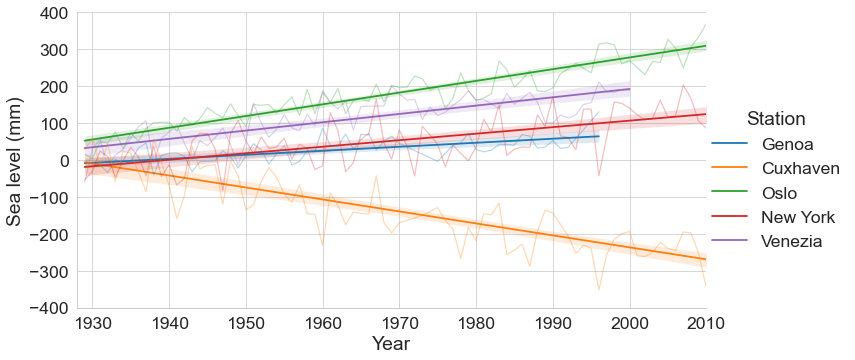

In [31]:
sns.set_style("whitegrid")
sns.set_context("paper", font_scale=2)
ax=sns.lmplot(x='Time', y='WL_bench',hue='Station',data=tides_clip,scatter=False,height=5,aspect=2,ci=99)
#plt.fill_between(Global_clip['Year'],
#                 Global_clip['WL_bench']-Global_clip['standard deviation (mm)'],
#                 Global_clip['WL_bench']+Global_clip['standard deviation (mm)'],
#                 alpha=0.2, facecolor='k',label='Global')
ax=sns.lineplot(data=tides_clip, x='Time', y='WL_bench',hue='Station',legend=False,alpha=0.3)
ax.set(xlabel='Year', ylabel='Sea level (mm)',ylim=[-400,400],xlim=[ref_time,2010])
plt.savefig('tideplot.png', dpi=300,format='png',transparent=True)